# Fermi limits with Sommerfeld enhancement

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

At freeze-out, we want
$$
\langle \sigma v \rangle _{relic} = \frac{\pi \alpha^2}{M^2} S_{FO} = \frac{\pi \alpha^2}{M^2} 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}}
$$
where $1/v=4$ at freeze-out. We also know that $\langle \sigma v \rangle _{relic} = 2.2\times 10^{-26} \mathrm{cm}^3 \mathrm{s}^{-1}$ for self-conjugate DM (this is the model they use in reference [13]). We want to use the equation above to derive $\alpha(M)$ that reproduces the correct relic abundance, but the equation does not have an analytic solution. Below I solve it numerically.

In [6]:
sigmav_conversion = 1.52 * 10 ** 24 / (5.06 * 10 ** 13) ** 3 # Converts from GeV^-2 to cm^3s^-1
sigmav_relic = 2.2 * 10**(-26) / sigmav_conversion # GeV^-2
vrel_FO = 1 / 4

def gen(M):
	return lambda alpha : sigmav_relic - np.pi * alpha ** 2 / M ** 2 * 2 * np.pi * alpha / vrel_FO / (1 - np.exp(-2 * np.pi * alpha / vrel_FO))

def alpha(M):
	return opt.fsolve(gen(M), 0.1)[0]

def simple_alpha(M):
	return M * np.sqrt(sigmav_relic / np.pi)

Below I'm plotting the dependence of $\alpha$ on $M$ with this new equation, and I'm comparing it to the one I found in excercise 3.3 which was just a linear dependence.

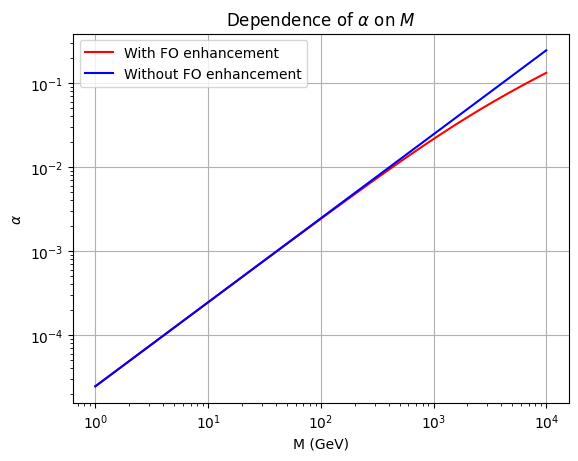

In [7]:
plt.title("Dependence of $\\alpha$ on $M$")
plt.xlabel("M (GeV)")
plt.ylabel("$\\alpha$")
plt.xscale("log")
plt.yscale("log")
M_axis = np.logspace(0,4)
plt.grid()
plt.plot(M_axis, list(map(alpha, M_axis)), color="red", label="With FO enhancement");
plt.plot(M_axis, list(map(simple_alpha, M_axis)), color="blue", label="Without FO enhancement");
plt.legend();

I now use the result from the previous equation to calculate the enhanced cross-section relevant for the Fermi limits today. From the literature, I gathered that $v \simeq 10 \mathrm{km}/\mathrm{s}$ in dwarf spheroidal galaxies, which are the object of study of the Fermi collaboration. The enhanced cross-section is
$$
\langle \sigma v \rangle _{dSph} = \frac{\pi \alpha^2}{M^2} S_{dSph} = \frac{\pi \alpha^2}{M^2} 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}}
$$

In [8]:
vrel_dSph = 10 / 300000 # 10 km/s in units of c

def sigmav_now(M):
	a = alpha(M)
	coefficient = 2 * np.pi * a / vrel_dSph
	return sigmav_conversion * np.pi * a ** 2 / M ** 2 * coefficient / (1 - np.exp(-coefficient))

Below I plot the enhanced cross-section as a function of $M$.

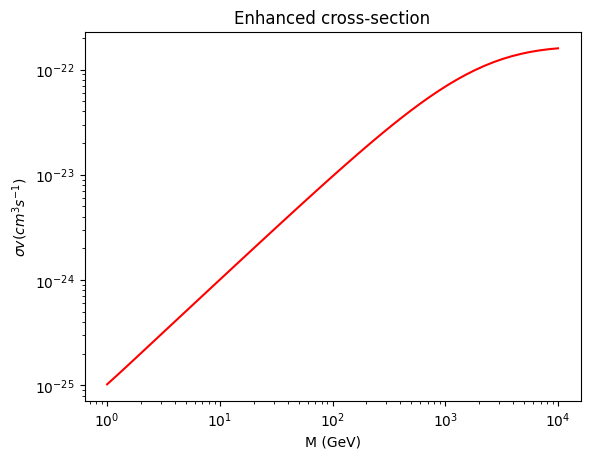

In [9]:
plt.title("Enhanced cross-section")
plt.xlabel("M (GeV)")
plt.ylabel("$\\sigma v (cm^3s^{-1})$")
plt.xscale("log")
plt.yscale("log")
plt.plot(M_axis, list(map(sigmav_now, M_axis)), color="red");

This is the graph from reference [13].

![fig6.png](fig6.png)

It appears to me that no constraint can be put on $M$, as the enhanced cross-section is always above the dSph $4\tau$ graph for the range taken into consideration ($1-10^4\mathrm{GeV}$).